In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from model_ex_1 import GasSimulation3D
from model_ex_2 import GasSimulation3DWithCollisions
from model_ex_3 import GasSimulation3DWithLennardJones
from compare_models import compare_models_T, compare_models_N, compare_models_V

In [ ]:
models = {
    'Ideal Gas': GasSimulation3D,
    'Hard Spheres': GasSimulation3DWithCollisions,
    'Lennard-Jones': GasSimulation3DWithLennardJones
}
microparams = {
    'Ideal Gas': {'dt': 1e-14},
    'Hard Spheres': {'dt': 1e-14, 'radius': 1.6e-10},
    'Lennard-Jones': {
        'dt': 1e-16, 'radius': 1.6e-10,
        'epsilon': 1.65e-21, 'sigma_LJ': 3.4e-10,
        'r_cutoff': 2.5 * 3.4e-10
    }
}
common = {'N': 500, 'L': 1e-7, 'T': 120.0, 'steps': 10000, 'm': 6.63e-26}

seed=12345


In [4]:

def sweep_T_with_replicates(model, T_list, n_repeats=30):
    """
    Для каждого T из T_list запускает n_repeats симуляций, считает среднее и std давления.
    Возвращает DataFrame с колонками:
    'T', 'P_mean', 'P_std', 'P_ideal', 'T_actual_mean', 'P_error_mean' и др.
    """
    records = []
    original_T = model.T

    try:
        for T in tqdm(T_list, desc="Sweep T with replicates"):
            setattr(model, 'T', T)

            pressures = []
            collisions_total = 0
            T_actuals = []

            for _ in range(n_repeats):
                P_sim, collisions = model.run()
                pressures.append(P_sim)
                collisions_total += collisions
                T_actuals.append(model.actual_temperature())  # Если актуальная T меняется в run

            pressures = np.array(pressures)
            P_mean = pressures.mean()
            P_std = pressures.std(ddof=1)

            P_ideal = model.ideal_pressure()
            T_actual_mean = np.mean(T_actuals)
            P_err_mean = np.abs(P_mean - P_ideal) / P_ideal * 100

            V = model.L**3
            collision_rate = collisions_total / (model.steps * model.dt * n_repeats)

            records.append({
                'T': T,
                'P_mean': P_mean,
                'P_std': P_std,
                'P_ideal': P_ideal,
                'T_actual_mean': T_actual_mean,
                'P_error_mean': P_err_mean,
                'Volume': V,
                'N_particles': model.N,
                'Collision_rate': collision_rate
            })
    finally:
        setattr(model, 'T', original_T)

    return pd.DataFrame(records)


In [5]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

kB = 1.380649e-23  # Больцмановская константа

def P_vdw(T, a, b, N, V):
    return N * kB * T / (V - b * N) - a * N**2 / V**2

def plot_pressure_vs_T(df, model_name):
    Ts = df['T'].values
    Ps = df['P_mean'].values
    Ps_err = df['P_std'].values
    N = df['N_particles'].iloc[0]
    V = df['Volume'].iloc[0]

    # Подгонка параметров a,b
    popt, pcov = curve_fit(lambda T, a, b: P_vdw(T, a, b, N, V), Ts, Ps, sigma=Ps_err, absolute_sigma=True, p0=[1e-21, 1e-29])

    plt.errorbar(Ts, Ps, yerr=Ps_err, fmt='o', label=f'{model_name} Simulation')
    plt.plot(Ts, N * kB * Ts / V, 'k--', label='Ideal Gas')
    plt.plot(Ts, P_vdw(Ts, *popt, N, V), 'r-', label='Van der Waals Fit')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (Pa)')
    plt.title(f'Pressure vs Temperature for {model_name}')
    plt.legend()
    plt.show()

    print(f"Fitted Van der Waals parameters: a={popt[0]:.3e}, b={popt[1]:.3e}")

In [ ]:
def plot_pressure_vs_T(df, model_name):
    Ts = df['T'].values
    Ps = df['P_mean'].values
    Ps_err = df['P_std'].values
    N = df['N_particles'].iloc[0]
    V = df['Volume'].iloc[0]

    # Обработка нулевых ошибок:
    epsilon = 1e-12
    Ps_err_safe = np.where(Ps_err == 0, epsilon, Ps_err)

    try:
        popt, pcov = curve_fit(
            lambda T, a, b: P_vdw(T, a, b, N, V),
            Ts, Ps, sigma=Ps_err_safe,
            absolute_sigma=True,
            p0=[1e-21, 1e-29]
        )
        vdW_curve = P_vdw(Ts, *popt, N, V)
        print(f"Fitted Van der Waals parameters: a={popt[0]:.3e}, b={popt[1]:.3e}")
    except Exception as e:
        print(f"Fit failed: {e}")
        vdW_curve = None

    plt.errorbar(Ts, Ps, yerr=Ps_err, fmt='o', label=f'{model_name} Simulation')
    plt.plot(Ts, N * kB * Ts / V, 'k--', label='Ideal Gas')
    if vdW_curve is not None:
        plt.plot(Ts, vdW_curve, 'r-', label='Van der Waals Fit')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (Pa)')
    plt.title(f'Pressure vs Temperature for {model_name}')
    plt.legend()
    plt.show()

In [12]:
ideal_model = GasSimulation3D(**{**common, **microparams['Ideal Gas']})

T_values = np.linspace(100, 500, 10)

df_ideal = sweep_T_with_replicates(ideal_model, T_values, n_repeats=30)


,T,P_mean,P_std,P_ideal,T_actual_mean,P_error_mean,Volume,N_particles,Collision_rate
0,100.000000,1345.055205,4.625214e-13,1380.000000,100.046183,2.532231,1.000000e-21,1000,3.490000e+12
1,144.444444,1897.553319,2.312607e-13,1993.333333,144.511153,4.805017,1.000000e-21,1000,4.110000e+12
2,188.888889,2512.497136,0.000000e+00,2606.666667,188.976124,3.612642,1.000000e-21,1000,4.700000e+12
3,233.333333,3101.614944,9.250427e-13,3220.000000,233.441094,3.676555,1.000000e-21,1000,5.230000e+12
4,277.777778,3665.873588,4.625214e-13,3833.333333,277.906064,4.368515,1.000000e-21,1000,5.680000e+12


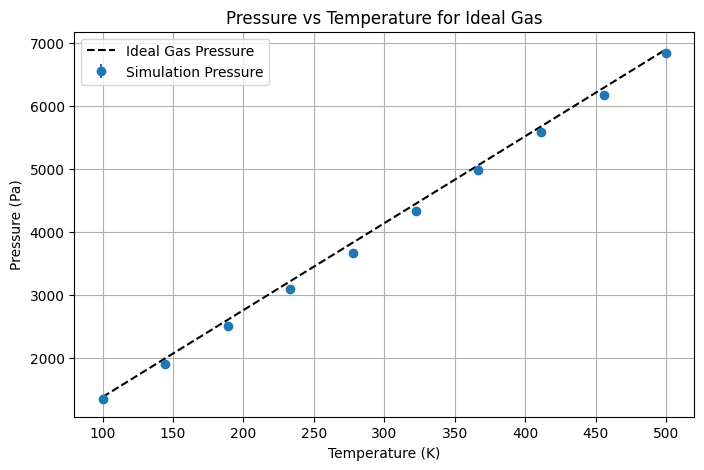

In [11]:


def plot_pressure_vs_temperature(df, model_name):
    T = df['T']
    P_mean = df['P_mean']
    P_std = df['P_std']
    P_ideal = df['P_ideal']

    plt.figure(figsize=(8,5))
    plt.errorbar(T, P_mean, yerr=P_std, fmt='o', label='Simulation Pressure')
    plt.plot(T, P_ideal, 'k--', label='Ideal Gas Pressure')

    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (Pa)')
    plt.title(f'Pressure vs Temperature for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pressure_vs_temperature(df_ideal, 'Ideal Gas')


Running sweep T for model: Ideal Gas


Sweep T with replicates: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


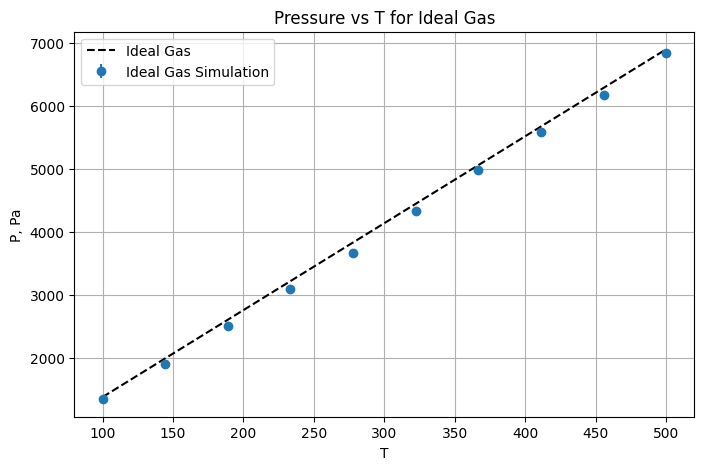


Running sweep T for model: Hard Spheres


Sweep T with replicates: 100%|██████████| 10/10 [19:19<00:00, 115.91s/it]

Hard Spheres Van der Waals fit parameters: a=3.581e-47, b=-2.005e-26


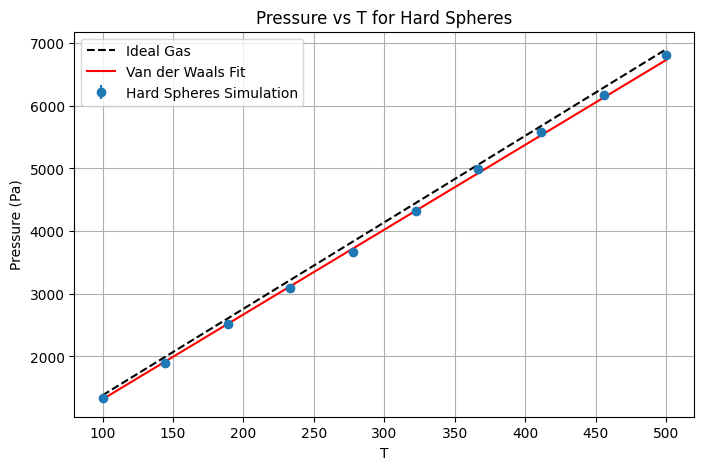


Running sweep T for model: Lennard-Jones


Sweep T with replicates: 100%|██████████| 10/10 [23:06<00:00, 138.60s/it]


Lennard-Jones Van der Waals fit parameters: a=7.176e-46, b=9.538e-26


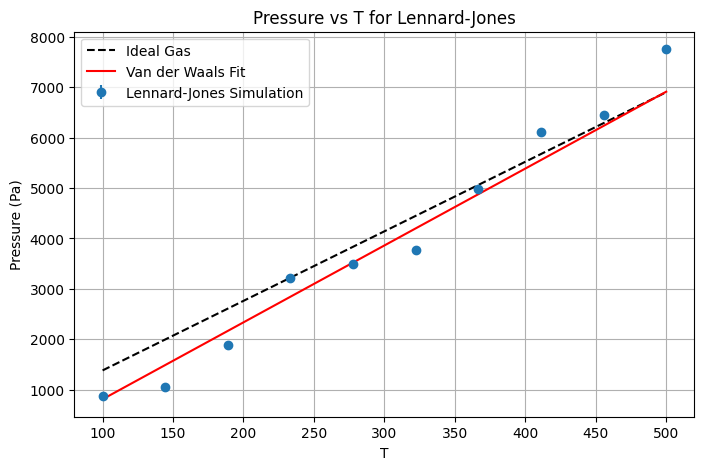


Running sweep L for model: Ideal Gas


Sweep L with replicates: 100%|██████████| 8/8 [01:22<00:00, 10.25s/it]


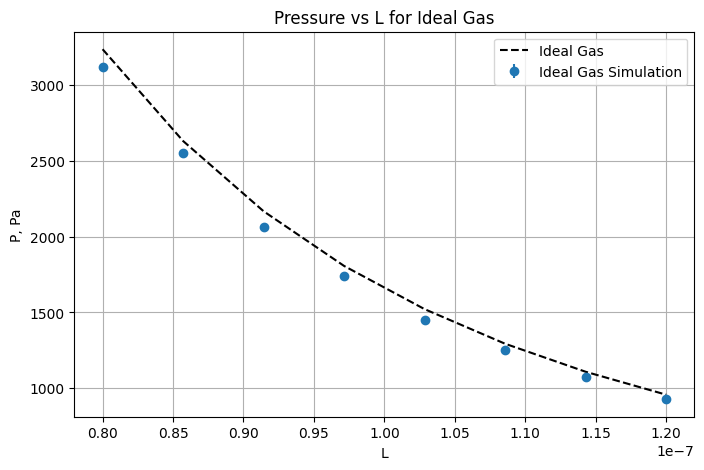


Running sweep L for model: Hard Spheres


Sweep L with replicates: 100%|██████████| 8/8 [15:15<00:00, 114.49s/it]

Hard Spheres Van der Waals fit parameters: a=-3.224e-46, b=1.000e-29



C:\Users\Stepan\AppData\Local\Temp\ipykernel_7840\302343936.py:95: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


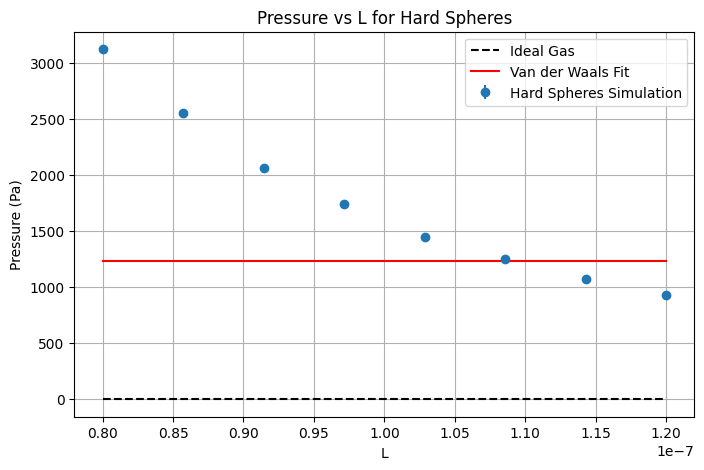


Running sweep L for model: Lennard-Jones


Sweep L with replicates: 100%|██████████| 8/8 [18:52<00:00, 141.55s/it]

Lennard-Jones Van der Waals fit parameters: a=-2.331e-46, b=1.000e-29


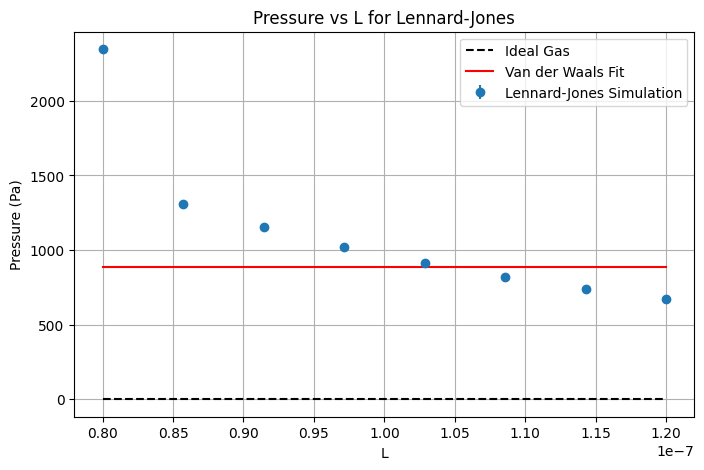


Running sweep N for model: Ideal Gas


Sweep N with replicates: 100%|██████████| 8/8 [01:19<00:00,  9.94s/it]


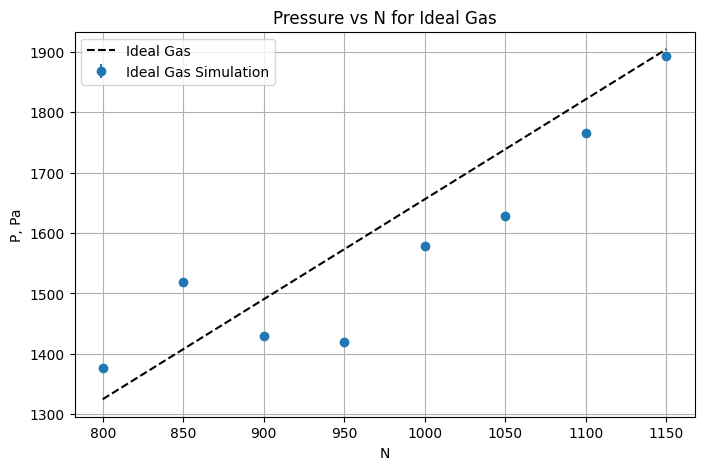


Running sweep N for model: Hard Spheres


Sweep N with replicates: 100%|██████████| 8/8 [14:40<00:00, 110.06s/it]

Hard Spheres Van der Waals fit parameters: a=-5.431e-46, b=-1.008e-23


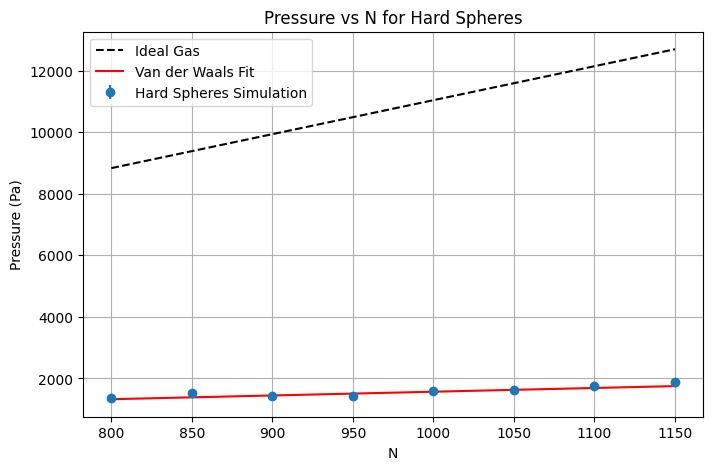


Running sweep N for model: Lennard-Jones


Sweep N with replicates: 100%|██████████| 8/8 [17:41<00:00, 132.71s/it]

Lennard-Jones Van der Waals fit parameters: a=-1.334e-45, b=-4.956e-17


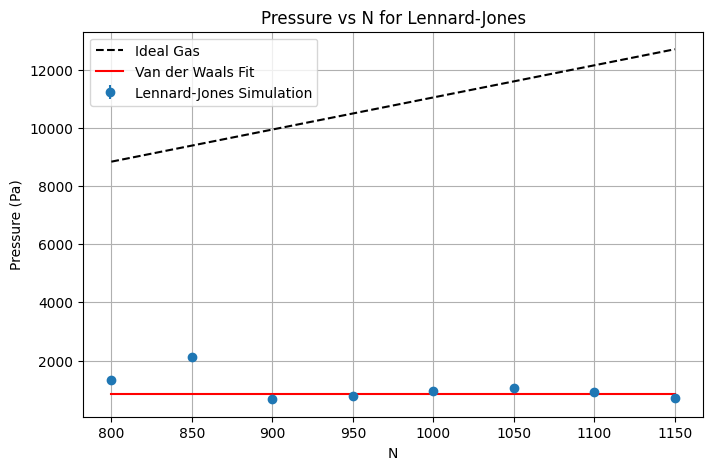

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

import copy
from concurrent.futures import ProcessPoolExecutor
from functools import partial

kB = 1.380649e-23  # Больцмановская константа

def sweep_with_replicates(model, param_name: str, values: np.ndarray, n_repeats=30):
    """
    Универсальный sweep по параметру param_name ('T', 'L', 'N'), с повторными запусками для error bars.
    Возвращает DataFrame с колонками:
    param_name, P_mean, P_std, P_ideal, T_actual_mean, P_error_mean, Volume, N_particles, Collision_rate
    """
    records = []
    original_value = getattr(model, param_name)
    
    try:
        for val in tqdm(values, desc=f"Sweep {param_name} with replicates"):
            setattr(model, param_name, val)
            pressures = []
            collisions_total = 0
            T_actuals = []

            for _ in range(n_repeats):
                P_sim, collisions = model.run()
                pressures.append(P_sim)
                collisions_total += collisions
                T_actuals.append(model.actual_temperature())

            pressures = np.array(pressures)
            P_mean = pressures.mean()
            P_std = pressures.std(ddof=1)

            P_ideal = model.ideal_pressure()
            T_actual_mean = np.mean(T_actuals)
            P_err_mean = np.abs(P_mean - P_ideal) / P_ideal * 100

            # Объем для газовой модели (куб длины бокса)
            V = model.L**3 if hasattr(model, 'L') else None
            Np = model.N if hasattr(model, 'N') else None
            collision_rate = collisions_total / (model.steps * model.dt * n_repeats)

            records.append({
                param_name: val,
                'P_mean': P_mean,
                'P_std': P_std,
                'P_ideal': P_ideal,
                'T_actual_mean': T_actual_mean,
                'P_error_mean': P_err_mean,
                'Volume': V,
                'N_particles': Np,
                'Collision_rate': collision_rate
            })
    finally:
        setattr(model, param_name, original_value)

    return pd.DataFrame(records)

def P_vdw(T, a, b, N, V):
    return N * kB * T / (V - b * N) - a * N**2 / V**2

def plot_sweep_vs_ideal(df, param_name, model_name):
    x = df[param_name]
    P_mean = df['P_mean']
    P_std = df['P_std']
    P_ideal = df['P_ideal']

    plt.figure(figsize=(8,5))
    plt.errorbar(x, P_mean, yerr=P_std, fmt='o', label=f'{model_name} Simulation')
    plt.plot(x, P_ideal, 'k--', label='Ideal Gas')
    plt.xlabel(param_name)
    plt.ylabel('P, Pa')
    plt.title(f'Pressure vs {param_name} for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sweep_vs_vdw(df, param_name, model_name):
    x = df[param_name]
    P_mean = df['P_mean']
    P_std = df['P_std']
    N = df['N_particles'].iloc[0]
    V = df['Volume'].iloc[0]

    # Обрабатываем нулевые std для curve_fit
    epsilon = 1e-12
    P_std_safe = np.where(P_std == 0, epsilon, P_std)

    try:
        popt, pcov = curve_fit(
            lambda T, a, b: P_vdw(T, a, b, N, V),
            x, P_mean,
            sigma=P_std_safe,
            absolute_sigma=True,
            p0=[1e-21, 1e-29]
        )
        P_fit = P_vdw(x, *popt, N, V)
        print(f"{model_name} Van der Waals fit parameters: a={popt[0]:.3e}, b={popt[1]:.3e}")
    except Exception as e:
        print(f"Van der Waals fit failed for {model_name}: {e}")
        P_fit = None

    plt.figure(figsize=(8,5))
    plt.errorbar(x, P_mean, yerr=P_std, fmt='o', label=f'{model_name} Simulation')
    plt.plot(x, N * kB * x / V, 'k--', label='Ideal Gas')
    if P_fit is not None:
        plt.plot(x, P_fit, 'r-', label='Van der Waals Fit')
    plt.xlabel(param_name)
    plt.ylabel('Pressure (Pa)')
    plt.title(f'Pressure vs {param_name} for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_and_plot_all(models_dict, sweep_param, param_values, n_repeats=30):
    """
    models_dict = {
        'Ideal Gas': ideal_model,
        'Hard Spheres': hard_spheres_model,
        'Lennard-Jones': lj_model
    }
    sweep_param = 'T' или 'L' или 'N' — параметр для sweep
    param_values = массив значений параметра
    """
    for name, model in models_dict.items():
        print(f"\nRunning sweep {sweep_param} for model: {name}")
        df = sweep_with_replicates(model, sweep_param, param_values, n_repeats=n_repeats)

        if name == 'Ideal Gas':
            # Сравниваем только с идеальным газом
            plot_sweep_vs_ideal(df, sweep_param, name)
            df.to_csv(f'{name}_{sweep_param}')
        else:
            # Для других — сравниваем с Ван-дер-Вальсом
            plot_sweep_vs_vdw(df, sweep_param, name)
            df.to_csv(f'{name}_{sweep_param}')

# Пример инициализации моделей (у вас должен быть соответствующий конструктор)
ideal_model = GasSimulation3D(**{**common, **microparams['Ideal Gas']})
hard_spheres_model = GasSimulation3DWithCollisions(**{**common, **microparams['Hard Spheres']})
lj_model = GasSimulation3DWithLennardJones(**{**common, **microparams['Lennard-Jones']})

# Пример использования:
T_values = np.linspace(100, 500, 10)
L_values = np.linspace(0.8e-7, 1.2e-7, 8)  # например
N_values = np.arange(800, 1200, 50)

models = {
     'Ideal Gas': ideal_model,
     'Hard Spheres': hard_spheres_model,
     'Lennard-Jones': lj_model
 }

run_and_plot_all(models, 'T', T_values, n_repeats=15)
run_and_plot_all(models, 'L', L_values, n_repeats=15)
run_and_plot_all(models, 'N', N_values, n_repeats=15)


Sweep T: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


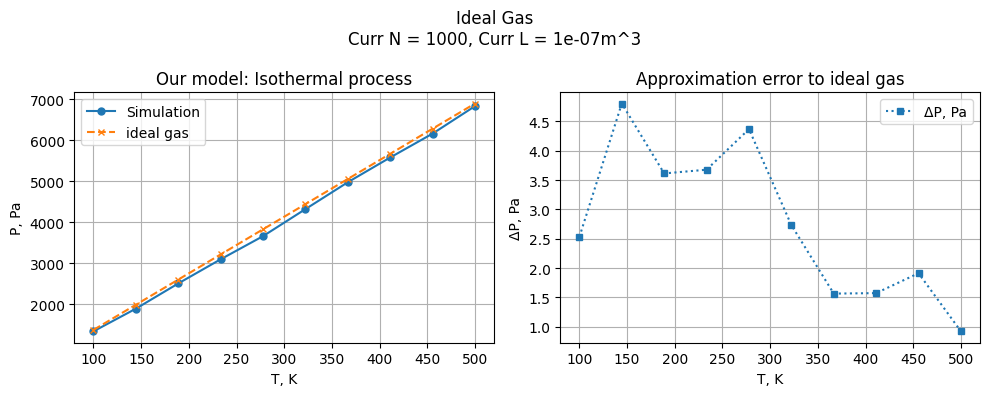

Sweep T: 100%|██████████| 10/10 [01:18<00:00,  7.81s/it]


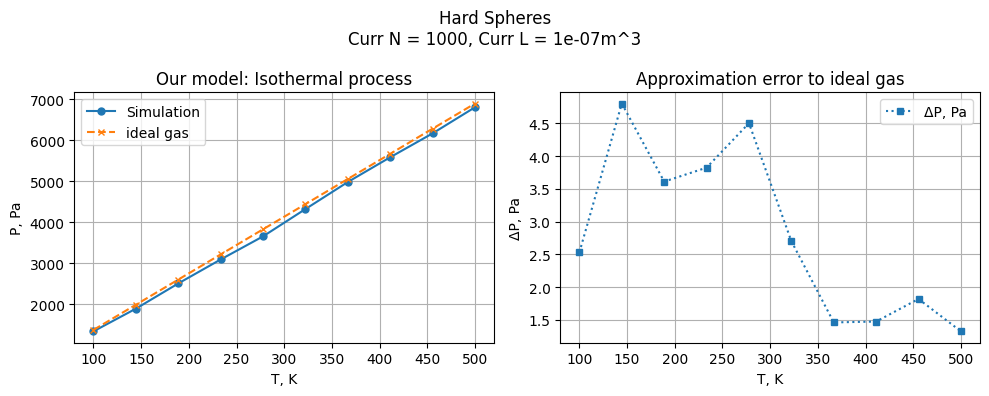

Sweep T: 100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


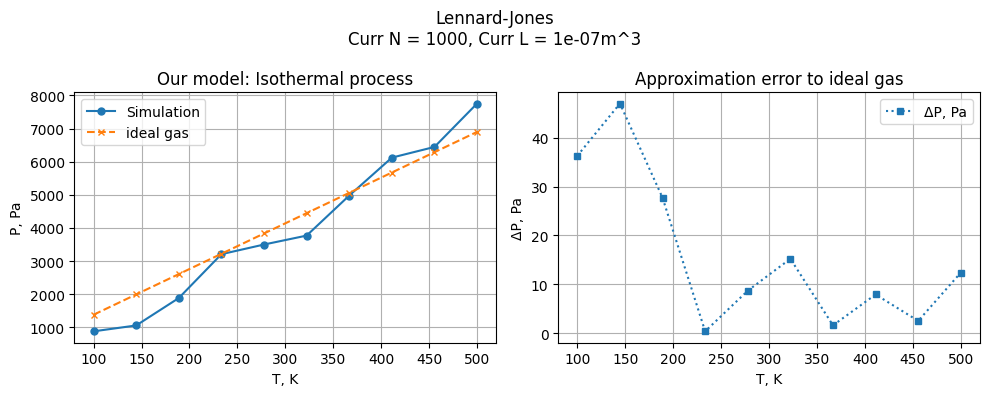

In [13]:
Tlist = np.linspace(100, 500, 10)
results_T = compare_models_T(models, microparams, common, Tlist, seed=seed)

Sweep N: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


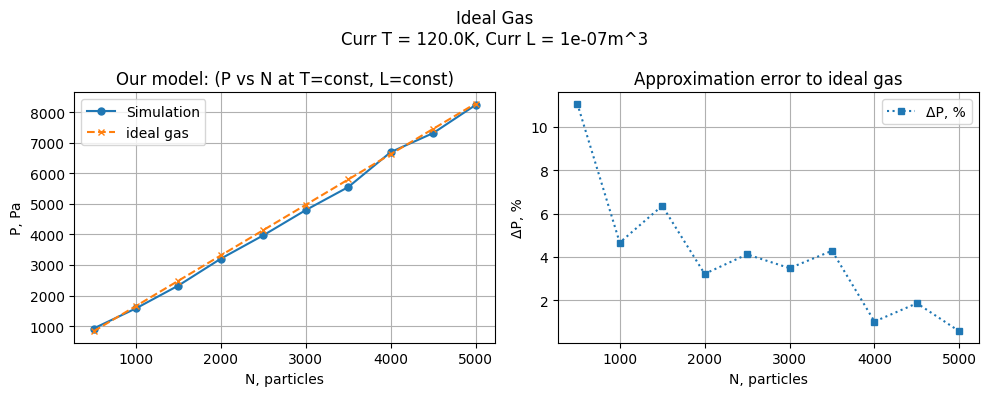

Sweep N: 100%|██████████| 10/10 [11:45<00:00, 70.53s/it] 


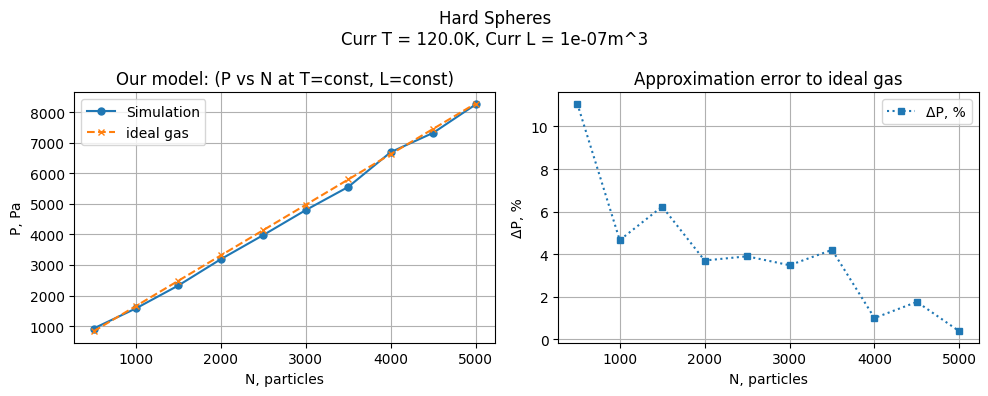

Sweep N: 100%|██████████| 10/10 [13:47<00:00, 82.78s/it] 


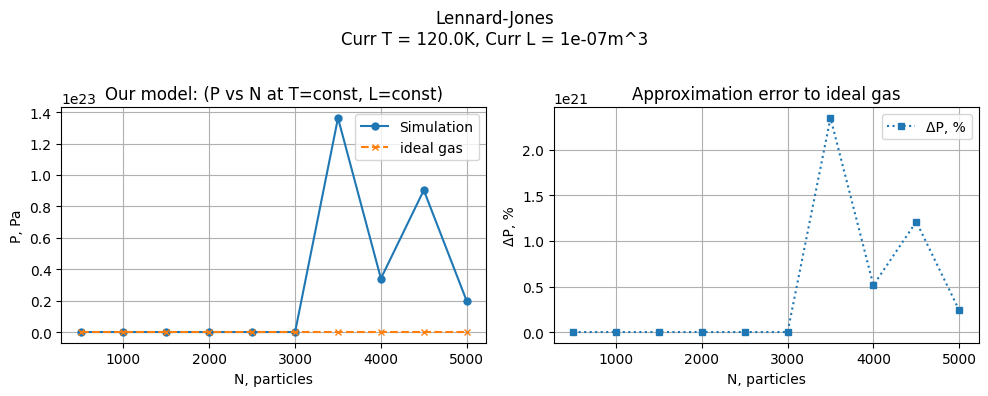

In [40]:
N_list = np.linspace(500, 5000, 10)
results_N = compare_models_N(models, microparams, common, N_list, seed=seed)

In [43]:
N_1_5k_df_id,  N_1_5k_df_hard, N_1_5k_df_Lennard= results_N.get('Ideal Gas'), results_N.get('Hard Spheres'), results_N.get('Lennard-Jones') 

In [44]:
N_1_5k_df_id.to_csv('N_1_5k_df_id')
N_1_5k_df_hard.to_csv('N_1_5k_df_hard')
N_1_5k_df_Lennard.to_csv('N_1_5k_df_Lennard')

In [50]:
N_1_5k_df_Lennard

,N,N (particles),P_sim (Pa),P_ideal (Pa),T_actual (K),T_ideal (K),Volume (m^3),Number of collisions,Collision rate (1/s),P_error (%),Total time (s)
0,500.0,500,7.017407e+02,828.0,1.239815e+02,120.0,1.000000e-21,2,2.000000e+12,1.524871e+01,1.000000e-12
1,1000.0,1000,9.628994e+02,1656.0,1.200686e+02,120.0,1.000000e-21,2,2.000000e+12,4.185390e+01,1.000000e-12
2,1500.0,1500,1.290557e+03,2484.0,1.198925e+02,120.0,1.000000e-21,3,3.000000e+12,4.804521e+01,1.000000e-12
3,2000.0,2000,6.353597e+03,3312.0,1.186181e+02,120.0,1.000000e-21,14,1.400000e+13,9.183567e+01,1.000000e-12
4,2500.0,2500,2.719158e+03,4140.0,1.192458e+02,120.0,1.000000e-21,5,5.000000e+12,3.431986e+01,1.000000e-12
5,3000.0,3000,3.127329e+03,4968.0,1.204056e+02,120.0,1.000000e-21,8,8.000000e+12,3.705053e+01,1.000000e-12
6,3500.0,3500,1.362680e+23,5796.0,9.804032e+30,120.0,1.000000e-21,44843,4.484300e+16,2.351069e+21,1.000000e-12
7,4000.0,4000,3.405651e+22,6624.0,6.307474e+30,120.0,1.000000e-21,10043,1.004300e+16,5.141382e+20,1.000000e-12
8,4500.0,4500,9.031033e+22,7452.0,5.595367e+30,120.0,1.000000e-21,28260,2.826000e+16,1.211894e+21,1.000000e-12
9,5000.0,5000,1.972839e+22,8280.0,4.854752e+30,120.0,1.000000e-21,8856,8.856000e+15,2.382656e+20,1.000000e-12


Из T_actual и P_sim видно, что прозошла какая-то "авария", можно это объяснить несколькими способами, тк наша модель учитывает силы взаимодействия между моелкулми, которые зависят от расстояния между ними, то вероятно, что из-за шага dt прозошло наложение частиц, из-за которого резко выросли скорости молекул, произошел взырыв

In [48]:
collisions_tail = N_1_5k_df_Lennard['Number of collisions'].iloc[3000:]
print(collisions_tail.head())

Series([], Name: Number of collisions, dtype: int64)


Важно следить за dt и числом шагов симуляции



Почти идеальнай пример, мы зафикисровали сиид у двух сравнений, стоит обратить внимание, где N=1000 на обоих графиках 

Sweep L: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


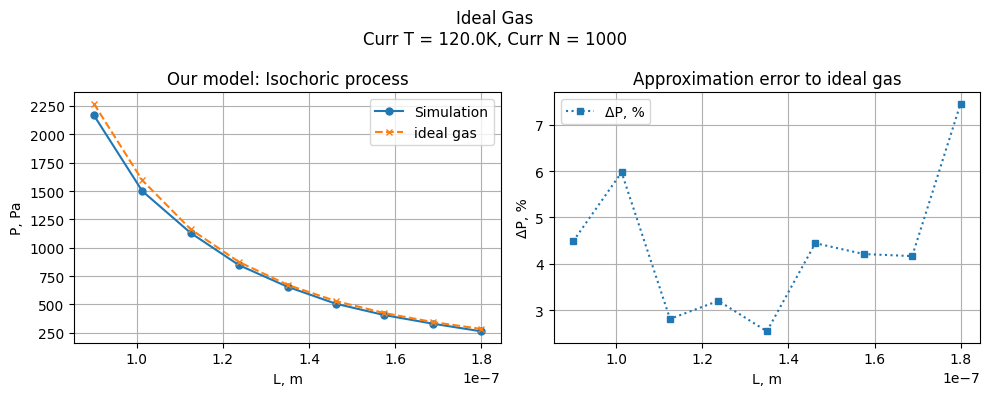

Sweep L: 100%|██████████| 9/9 [01:08<00:00,  7.63s/it]


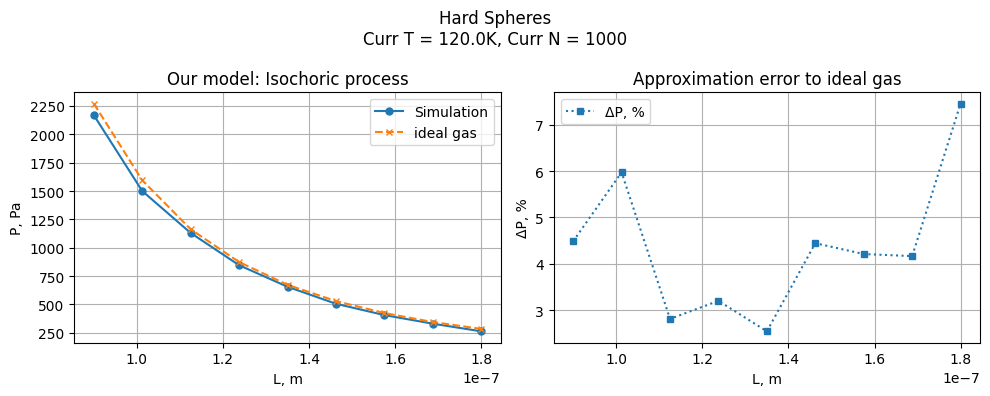

Sweep L: 100%|██████████| 9/9 [01:23<00:00,  9.28s/it]


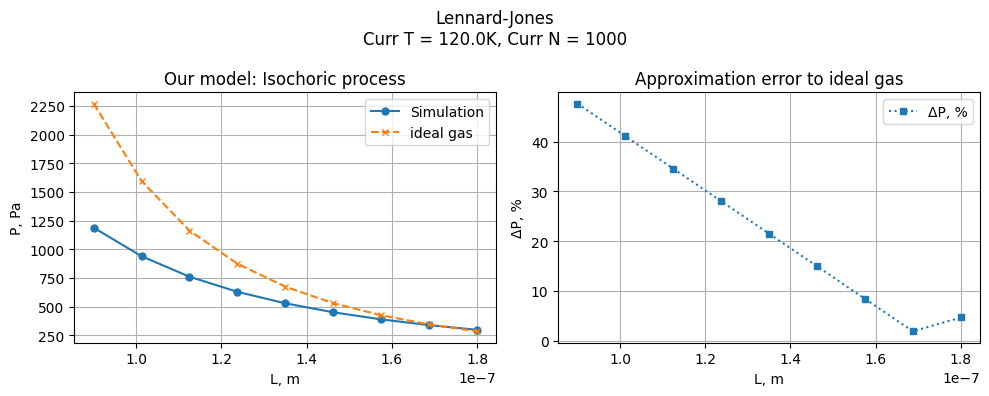

In [34]:
V_list = np.linspace(0.9e-7, 1.8e-7, 9)
results_V = compare_models_V(models, microparams, common, V_list, seed=12345)

In [20]:
ideal_gas = results_T.get('Ideal Gas')
ideal_gas.head()

,T,N (particles),P_sim (Pa),P_ideal (Pa),T_actual (K),T_ideal (K),Volume (m^3),Number of collisions,Collision rate (1/s),P_error (%),Total time (s)
0,200.0,1000,2644.290056,2760.0,200.092366,200.0,1.000000e-21,482,4.820000e+12,4.192389,1.000000e-10
1,250.0,1000,3308.232773,3450.0,250.115458,250.0,1.000000e-21,542,5.420000e+12,4.109195,1.000000e-10
2,300.0,1000,3968.376218,4140.0,300.138550,300.0,1.000000e-21,596,5.960000e+12,4.145502,1.000000e-10
3,350.0,1000,4667.531701,4830.0,350.161641,350.0,1.000000e-21,647,6.470000e+12,3.363733,1.000000e-10
4,400.0,1000,5456.602218,5520.0,400.184733,400.0,1.000000e-21,696,6.960000e+12,1.148511,1.000000e-10


Fitted parameters: a = 1.008e+02, b = 2.018e-02


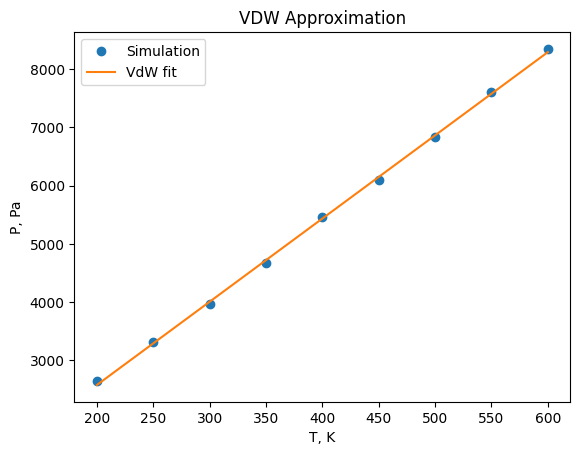

In [21]:
import numpy as np
from scipy.optimize import curve_fit

# результаты симуляции
T_list = np.linspace(200, 600, 9)     # список температур
P_sim  = ideal_gas['P_sim (Pa)']    # давление из sim

# константы
NA = 6.02214076e23           # Авогадро
R  = 8.314462618             # J/(mol·K)
N  = 1000                     # число частиц
V  = 1e-7**3                    # объём куба
n  = N/NA                    # число молей


def P_vdw_model(T, a, b):
    return (n*R*T)/(V - n*b) - a*(n**2)/(V**2)

# начальные приближения для [a, b]
p0 = [0.1, 1e-5]

# curve_fit вернёт оптимальные a и b
popt, pcov = curve_fit(P_vdw_model, T_list, P_sim, p0=p0)
a_fit, b_fit = popt

print(f'Fitted parameters: a = {a_fit:.3e}, b = {b_fit:.3e}')

import matplotlib.pyplot as plt

# рассчитываем теорию ван-дер-Ваальса на тех же T
P_fit = P_vdw_model(T_list, a_fit, b_fit)

plt.plot(T_list, P_sim, 'o', label='Simulation')
plt.plot(T_list, P_fit, '-', label='VdW fit')
plt.xlabel('T, K')
plt.ylabel('P, Pa')
plt.legend()
plt.title('VDW Approximation')
plt.show()


In [37]:
ideal_gas = results_V.get('Lennard-Jones')
ideal_gas.head()

,L,N (particles),P_sim (Pa),P_ideal (Pa),T_actual (K),T_ideal (K),Volume (m^3),Number of collisions,Collision rate (1/s),P_error (%),Total time (s)
0,9.000000e-08,1000,1188.764665,2271.604938,120.084927,120.0,7.290000e-22,2,2.000000e+12,47.668512,1.000000e-12
1,1.012500e-07,1000,939.270846,1595.420752,120.067324,120.0,1.037971e-21,2,2.000000e+12,41.127076,1.000000e-12
2,1.125000e-07,1000,760.809385,1163.061728,120.059880,120.0,1.423828e-21,2,2.000000e+12,34.585640,1.000000e-12
3,1.237500e-07,1000,628.768087,873.825491,120.056928,120.0,1.895115e-21,2,2.000000e+12,28.044204,1.000000e-12
4,1.350000e-07,1000,528.339851,673.068130,120.055831,120.0,2.460375e-21,2,2.000000e+12,21.502768,1.000000e-12


Fitted VdW parameters: a = -4.581e+02 Pa·m^6/mol^2, b = -1.577e+00 m^3/mol


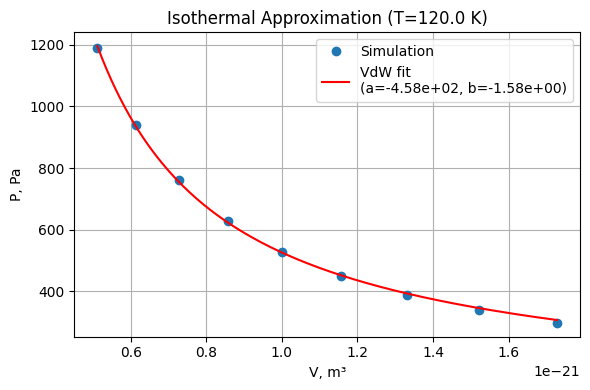

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1) Задаём параметры системы и данные симуляции
NA      = 6.02214076e23       # 1/моль
R       = 8.314462618         # Дж/(моль·К)
N       = 400                 # число частиц
T_const = 120.0               # K
L_list  = np.linspace(0.8e-7, 1.2e-7, 9)  # значения ребра куба, м
V_list  = L_list**3           # объёмы, м³

P_sim = ideal_gas['P_sim (Pa)']

# Молей:
n = N / NA
V = V_list  # объёмы при которых считали P_sim

# 2) Определяем модель P(V; a, b)
def P_vdw_of_V(V, a, b):
    # V — объём, a,b — параметры ван-дер-Ваальса
    return n*R*T_const/(V - n*b) - a*(n**2)/(V**2)

# 3) Подгоняем a и b
p0 = [0.136, 3.22e-5]  # начальные приближения по аргону
popt, pcov = curve_fit(P_vdw_of_V, V, P_sim, p0=p0)
a_fit, b_fit = popt
print(f'Fitted VdW parameters: a = {a_fit:.3e} Pa·m^6/mol^2, b = {b_fit:.3e} m^3/mol')

# 4) Визуализация
V_fine = np.linspace(V.min(), V.max(), 200)
P_fit   = P_vdw_of_V(V_fine, a_fit, b_fit)

plt.figure(figsize=(6,4))
plt.plot(V,     P_sim, 'o', label='Simulation')
plt.plot(V_fine,P_fit, 'r-', label=f'VdW fit\n(a={a_fit:.2e}, b={b_fit:.2e})')
plt.xlabel('V, m³')
plt.ylabel('P, Pa')
plt.title(f'Isothermal Approximation (T={T_const} K)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


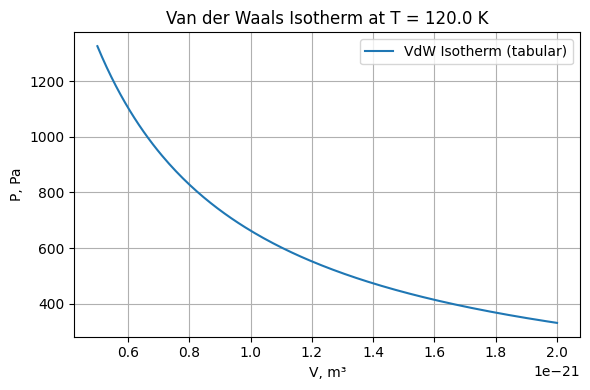

In [39]:
# Авогадро
NA = 6.02214076e23  
# Универсальная газовая постоянная
R  = 8.314462618  

def plot_vdw_isotherm(a: float, b: float, T: float, V_range: np.ndarray, N: int, label: str = 'VdW Isotherm (tabular)'):
    """
    Строит изотерму Ван-дер-Ваальса P(V) при заданной температуре T,
    параметрах a, b, и числе частиц N.
    """
    # число молей
    n = N / NA
    # давление по Ван-дер-Ваальсу
    P = (n * R * T) / (V_range - n * b) - a * (n**2) / (V_range**2)
    
    # Построение
    plt.figure(figsize=(6, 4))
    plt.plot(V_range, P, '-', label=label)
    plt.xlabel('V, m³')
    plt.ylabel('P, Pa')
    plt.title(f'Van der Waals Isotherm at T = {T} K')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Пример использования
a = 0.136           # Табличное значение для аргона, Pa·m^6/mol^2
b = 3.22e-5         # Табличное значение для аргона, m^3/mol
T = 120.0           # K
N = 400             # число частиц
V_range = np.linspace(0.5e-21, 2.0e-21, 200)

plot_vdw_isotherm(a, b, T, V_range, N)

В аннотация подводка к задаче

введение расширенная аннотация

Теор справка - часть введения
маленькие подпункты 